https://analyzecore.com/2015/02/16/customer-segmentation-lifecycle-grids-with-r/

I want to share a very powerful approach for customer segmentation in this post. It is based on customer’s lifecycle, specifically on frequency and recency of purchases. The idea of using these metrics comes from the RFM analysis. Recency and frequency are very important behavior metrics.

We are interested in frequent and recent purchases, because frequency affects client’s lifetime value and recency affects retention. Therefore, these metrics can help us to understand the current phase of the client’s lifecycle. When we know each client’s phase, we can split customer base into groups (segments) in order to:

* understand the state of affairs,
* effectively using marketing budget through accurate targeting,
* use different offers for every group,
* effectively using email marketing,
* increase customers’ life-time and value, finally.

For this, we will use a matrix called LifeCycle Grids. We will study how to process initial data (transaction) to the matrix, how to visualize it, and how to do some in-depth analysis. We will do all these steps with the R programming language.

## Create DataFrames

In [1]:
# loading libraries
library(dplyr)
library(reshape2)
library(ggplot2)
options(warn=0)
 
# creating data sample
set.seed(10)

data <- data.frame(
    orderId=sample(c(1:1000), 5000, replace=TRUE),
    product=sample(c('NULL','a','b','c'), 5000, replace=TRUE,
    prob=c(0.15, 0.65, 0.3, 0.15)))

order <- data.frame(
    orderId=c(1:1000),
    clientId=sample(c(1:300), 1000, replace=TRUE))

gender <- data.frame(
    clientId=c(1:300),
    gender=sample(c('male', 'female'), 300, replace=TRUE, prob=c(0.40, 0.60)))

date <- data.frame(
    orderId=c(1:1000),
    orderdate=sample((1:100), 1000, replace=TRUE))



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
head(data)

,orderId,product
1,508,a
2,307,a
3,427,a
4,694,c
5,86,b
6,226,c


In [3]:
head(order)

,orderId,clientId
1,1,254
2,2,151
3,3,118
4,4,202
5,5,167
6,6,93


In [4]:
head(gender)

,clientId,gender
1,1,male
2,2,female
3,3,female
4,4,female
5,5,male
6,6,female


In [5]:
head(date)

,orderId,orderdate
1,1,93
2,2,30
3,3,45
4,4,66
5,5,30
6,6,7


## Merge DataFrames

In [6]:
orders <- merge(data, order, by='orderId')
head(orders)

,orderId,product,clientId
1,1,a,254
2,1,b,254
3,1,c,254
4,1,b,254
5,2,a,151
6,2,NULL,151


In [7]:
orders <- merge(orders, gender, by='clientId')
head(orders)

,clientId,orderId,product,gender
1,1,457,a,male
2,1,76,a,male
3,1,457,a,male
4,1,457,b,male
5,1,457,b,male
6,1,457,a,male


In [8]:
orders <- merge(orders, date, by='orderId')
head(orders)

,orderId,clientId,product,gender,orderdate
1,1,254,a,female,93
2,1,254,b,female,93
3,1,254,c,female,93
4,1,254,b,female,93
5,2,151,a,female,30
6,2,151,b,female,30


The head of our data sample looks like:

You can see that there is a gender of customer in the table. 

We will use it as an example of some in-depth analysis later. 

I recommend you to use any additional features, that you have, for seeking insights. It can be source of client, channel, campaign, geo data and so on.

In [9]:
orders <- orders[orders$product!='NULL',]
orders$orderdate <- as.Date(orders$orderdate, 
                            origin="2012-01-01")

head(orders)

,orderId,clientId,product,gender,orderdate
1,1,254,a,female,15433
2,1,254,b,female,15433
3,1,254,c,female,15433
4,1,254,b,female,15433
5,2,151,a,female,15370
6,2,151,b,female,15370


A few words about LifeCycle Grids. It is a matrix with 2 dimensions:

* **frequency**, which is expressed in number of purchased items or placed orders,

* **recency**, which is expressed in days or months since the last purchase.

The first step is to think about suitable grids for your business. 

It is impossible to work with infinite segments. 

Therefore, we need to define some boundaries of frequency and recency, which should help us to split customers into homogeneous groups (segments). 

The analysis of the distribution of the frequency and the recency in our data set combined with the knowledge of business aspects can help us to find suitable boundaries.

Therefore, we need to calculate two values:

1. Number of orders that were placed by each client (or in some cases, it can be the number of items)

2. Time lapse from the last purchase to the reporting date.

Then, plot the distribution with the following code:

In [10]:
# reporting date
today <- as.Date('2012-04-11', format='%Y-%m-%d')
 
# processing data
orders <- dcast(
    orders, 
    orderId + clientId + gender + orderdate ~ product, 
    value.var='product', fun.aggregate=length)
 
orders <- orders %>%
 group_by(clientId) %>%
 mutate(frequency=n(),
 recency=as.numeric(today-orderdate)) %>%
 filter(orderdate==max(orderdate)) %>%
 filter(orderId==max(orderId)) %>%
 ungroup()

In [11]:
head(orders)

,orderId,clientId,gender,orderdate,a,b,c,frequency,recency
1,1,254,female,15433,1,2,1,9,8
2,4,202,female,15406,2,1,0,3,35
3,14,127,female,15401,6,0,1,2,40
4,30,250,female,15426,1,0,0,4,15
5,38,299,female,15438,5,2,0,3,3
6,41,230,female,15416,4,1,1,2,25


Warning message:
: `geom_bar()` no longer has a `binwidth` parameter. Please use `geom_histogram()` instead.

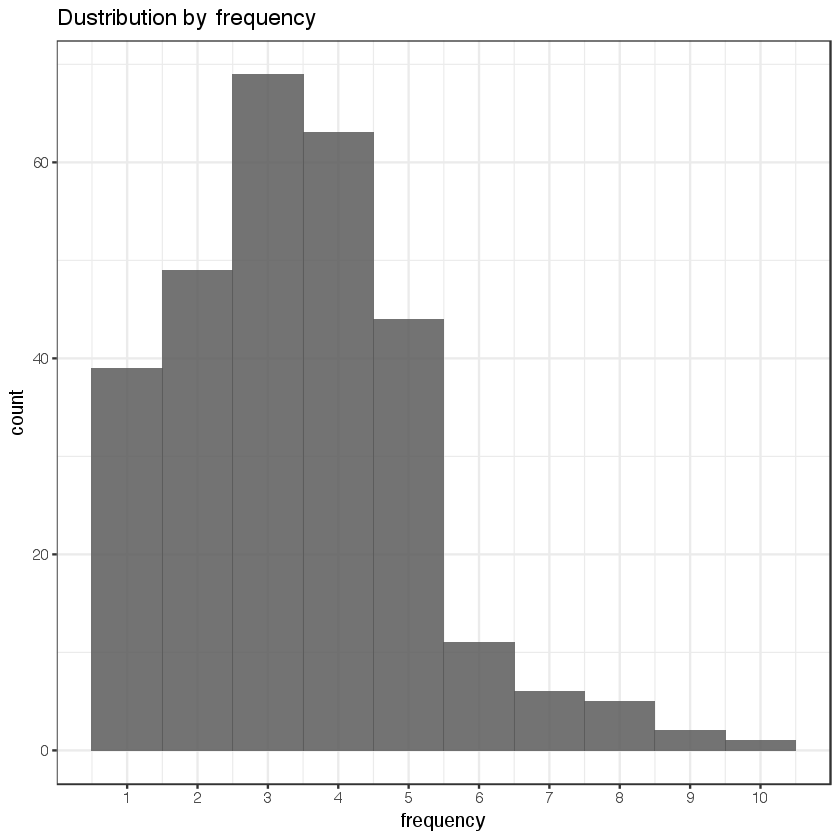

In [13]:
# exploratory analysis
ggplot(orders, aes(x=frequency)) +
 theme_bw() +
 scale_x_continuous(breaks=c(1:10)) +
 geom_bar(alpha=0.6, binwidth=1) +
 geom_histogram(alpha=0.6, binwidth=1) +
 ggtitle("Dustribution by frequency")

Warning message:
: `geom_bar()` no longer has a `binwidth` parameter. Please use `geom_histogram()` instead.

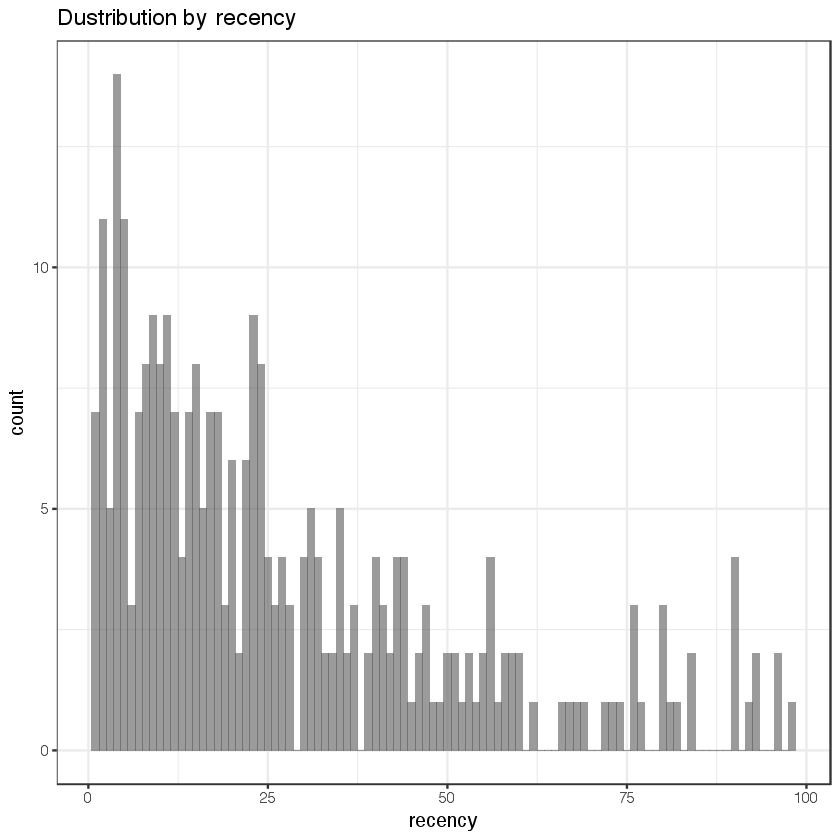

In [14]:
ggplot(orders, aes(x=recency)) +
 theme_bw() +
 geom_bar(alpha=0.6, binwidth=1) +
 ggtitle("Dustribution by recency")

Early behavior is most important, so finer detail is good there. Usually, there is a significant difference between customers who bought 1 time and those who bought 3 times, but is there any difference between customers who bought 50 times and other who bought 53 times? That is why it makes sense to set boundaries from lower values to higher gaps. We will use the following boundaries:

* for frequency: 1, 2, 3, 4, 5, >5,
* for recency: 0-6, 7-13, 14-19,  20-45, 46-80, >80

Next, we need to add segments to each client based on the boundaries. Also, we will create new variable ‘cart’, which includes products from the last cart, for doing in-depth analysis.

## Segments

In [15]:
orders.segm <- orders %>%
 mutate(segm.freq=ifelse(between(frequency, 1, 1), '1',
 ifelse(between(frequency, 2, 2), '2',
 ifelse(between(frequency, 3, 3), '3',
 ifelse(between(frequency, 4, 4), '4',
 ifelse(between(frequency, 5, 5), '5', '>5')))))) %>%
 mutate(segm.rec=ifelse(between(recency, 0, 6), '0-6 days',
 ifelse(between(recency, 7, 13), '7-13 days',
 ifelse(between(recency, 14, 19), '14-19 days',
 ifelse(between(recency, 20, 45), '20-45 days',
 ifelse(between(recency, 46, 80), '46-80 days', '>80 days')))))) %>%
 # creating last cart feature
 mutate(cart=paste(ifelse(a!=0, 'a', ''),
 ifelse(b!=0, 'b', ''),
 ifelse(c!=0, 'c', ''), sep='')) %>%
 arrange(clientId)
 
# defining order of boundaries
orders.segm$segm.freq <- factor(orders.segm$segm.freq, levels=c('>5', '5', '4', '3', '2', '1'))
orders.segm$segm.rec <- factor(orders.segm$segm.rec, levels=c('>80 days', '46-80 days', '20-45 days', '14-19 days', '7-13 days', '0-6 days'))

In [18]:
head(orders.segm)

,orderId,clientId,gender,orderdate,a,b,c,frequency,recency,segm.freq,segm.rec,cart
1,808,1,male,15421,2,2,0,4,20,4,20-45 days,ab
2,375,2,female,15418,5,1,0,3,23,3,20-45 days,ab
3,566,3,female,15432,2,0,2,4,9,4,7-13 days,ac
4,805,4,female,15401,5,2,0,4,40,4,20-45 days,ab
5,268,5,male,15388,3,0,1,4,53,4,46-80 days,ac
6,796,6,female,15428,4,2,0,4,13,4,7-13 days,ab


We have everything need to create LifeCycle Grids. We need to combine clients into segments with the following code:

In [16]:
lcg <- orders.segm %>%
 group_by(segm.rec, segm.freq) %>%
 summarise(quantity=n()) %>%
 mutate(client='client') %>%
 ungroup()

The classic matrix can be created with the following code:

In [20]:
lcg.matrix <- dcast(lcg, segm.freq ~ segm.rec, value.var='quantity', fun.aggregate=sum)
head(lcg.matrix)

,segm.freq,>80 days,46-80 days,20-45 days,14-19 days,7-13 days,0-6 days
1,>5,0,1,6,4,7,7
2,5,0,1,15,8,9,11
3,4,0,1,21,9,20,12
4,3,0,10,25,11,10,13
5,2,2,17,18,3,4,5
6,1,12,13,7,2,2,3


However, I suppose a good visualization is obtained through the following code:

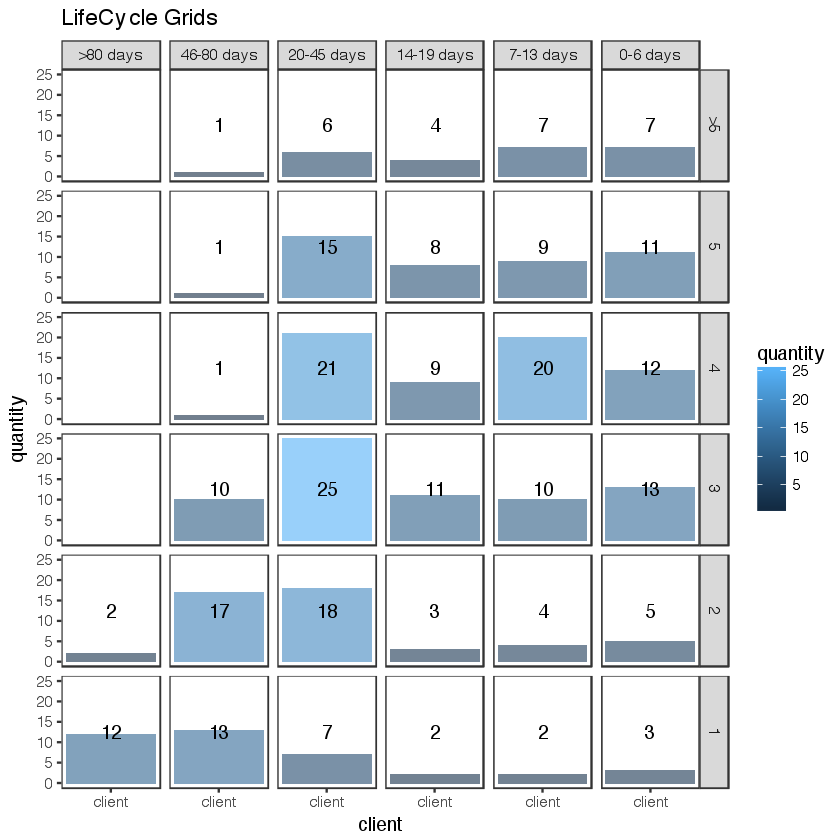

In [21]:
ggplot(lcg, aes(x=client, y=quantity, fill=quantity)) +
 theme_bw() +
 theme(panel.grid = element_blank())+
 geom_bar(stat='identity', alpha=0.6) +
 geom_text(aes(y=max(quantity)/2, label=quantity), size=4) +
 facet_grid(segm.freq ~ segm.rec) +
 ggtitle("LifeCycle Grids")

I’ve added colored borders for a better understanding of how to work with this matrix. We have four quadrants:

* yellow – here are our best customers, who have placed quite a few orders and made their last purchase recently. They have higher value and higher potential to buy again. We have to take care of them.

* green – here are our new clients, who placed several orders (1-3) recently. Although they have lower value, they have potential to move into the yellow zone. Therefore, we have to help them move into the right quadrant (yellow).

* red – here are our former best customers. We need to understand why they are former and, maybe, try to reactivate them.

* blue – here are our onetime-buyers.

Hint: it is possible to highlight customer groups with different colors like the following examples:

In [24]:
lcg.adv <- lcg %>%
 mutate(rec.type = ifelse(segm.rec %in% c(">80 days", "46-80 days", "20-45 days"), "not recent", "recent"),
 freq.type = ifelse(segm.freq %in% c(">5", "5", "4"), "frequent", "infrequent"),
 customer.type = interaction(rec.type, freq.type))

head(lcg.adv)

,segm.rec,segm.freq,quantity,client,rec.type,freq.type,customer.type
1,>80 days,2,2,client,not recent,infrequent,not recent.infrequent
2,>80 days,1,12,client,not recent,infrequent,not recent.infrequent
3,46-80 days,>5,1,client,not recent,frequent,not recent.frequent
4,46-80 days,5,1,client,not recent,frequent,not recent.frequent
5,46-80 days,4,1,client,not recent,frequent,not recent.frequent
6,46-80 days,3,10,client,not recent,infrequent,not recent.infrequent


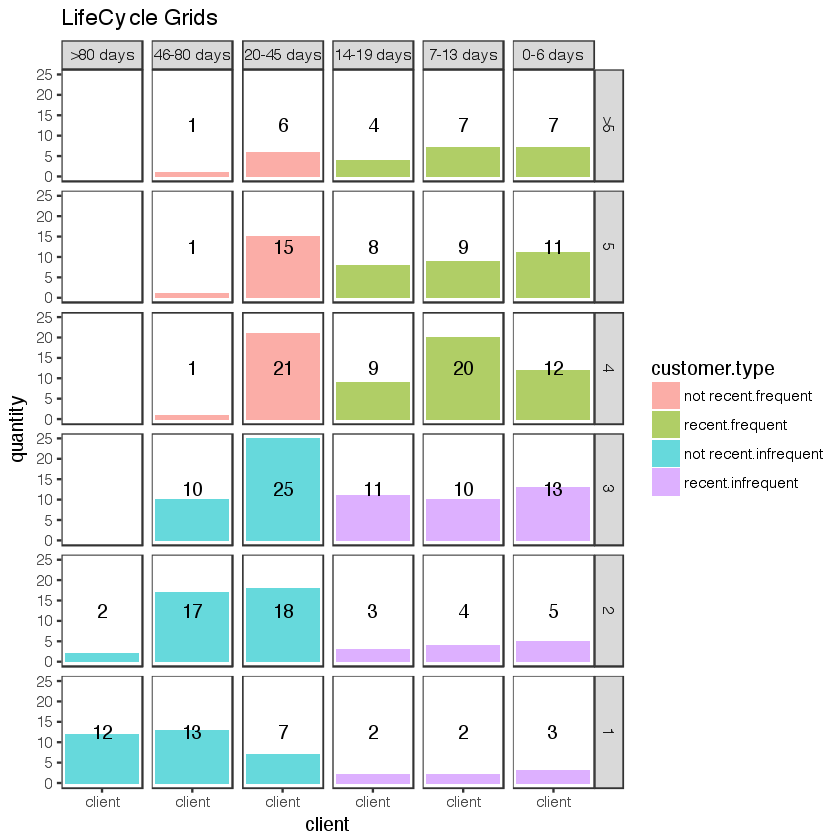

In [25]:
ggplot(lcg.adv, aes(x=client, y=quantity, fill=customer.type)) +
 theme_bw() +
 theme(panel.grid = element_blank()) +
 facet_grid(segm.freq ~ segm.rec) +
 geom_bar(stat='identity', alpha=0.6) +
 geom_text(aes(y=max(quantity)/2, label=quantity), size=4) +
 ggtitle("LifeCycle Grids")

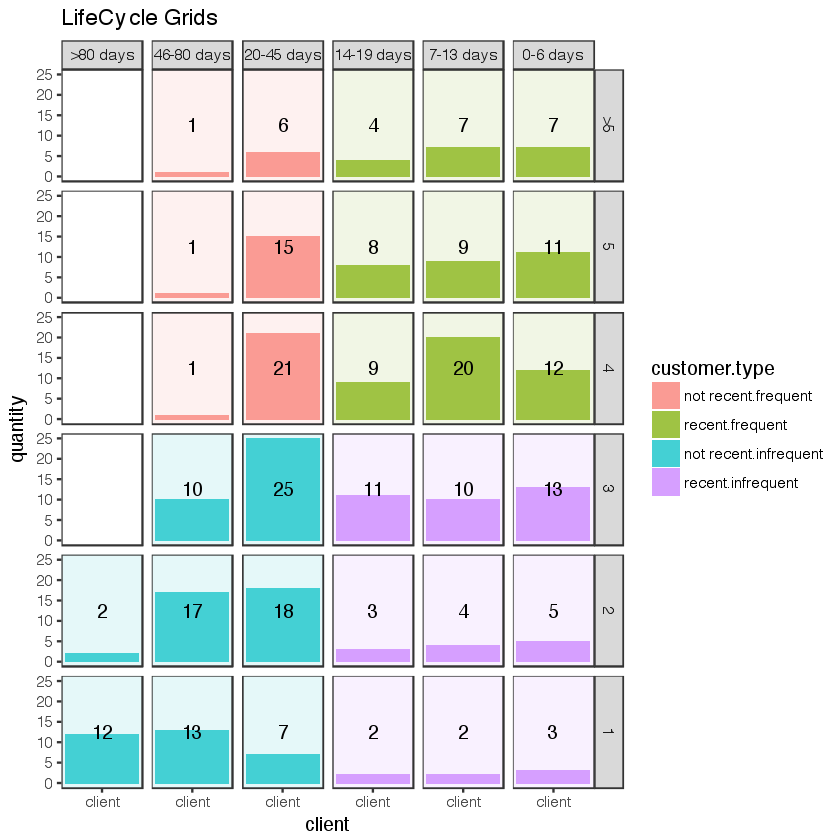

In [28]:
# with background
ggplot(lcg.adv, aes(x=client, y=quantity, fill=customer.type)) +
 theme_bw() +
 theme(panel.grid = element_blank()) +
 geom_rect(aes(fill = customer.type), xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, alpha = 0.1) +
 facet_grid(segm.freq ~ segm.rec) +
 geom_bar(stat='identity', alpha=0.7) +
 geom_text(aes(y=max(quantity)/2, label=quantity), size=4) +
 ggtitle("LifeCycle Grids")

Does it make sense to make the same offer to all of these customers? Certainly, it doesn’t! It makes sense to create different approaches not only for each quadrant, but for border cells as well.

What I really like about this model of segmentation is that it is stable and alive simultaneously. It is alive in terms of customers flow. Every day, with or without purchases, it will provide customers flow from one cell to another. And it is stable in terms of working with segments. It allows to work with customers who are on the same lifecycle phase. That means you can create suitable campaigns / offers / emails for each or several close cells and use them constantly.

Ok, it’s time to study how we can do some in-depth analysis. R allows us to create subsegments and visualize them effectively. It can be helpful to distribute each cell via some features. For instance, there can distribute customers by gender. For the other example, where our products have different lifecycles, it can be helpful to analyze which product/s was/were in the last cart or we can combine these features. Let’s do this with the following code:

In [29]:
lcg.sub <- orders.segm %>%
 group_by(gender, cart, segm.rec, segm.freq) %>%
 summarise(quantity=n()) %>%
 mutate(client='client') %>%
 ungroup()

head(lcg.sub)

,gender,cart,segm.rec,segm.freq,quantity,client
1,female,a,>80 days,1,1,client
2,female,a,46-80 days,1,2,client
3,female,a,20-45 days,>5,1,client
4,female,a,20-45 days,5,1,client
5,female,a,20-45 days,4,3,client
6,female,a,20-45 days,2,2,client


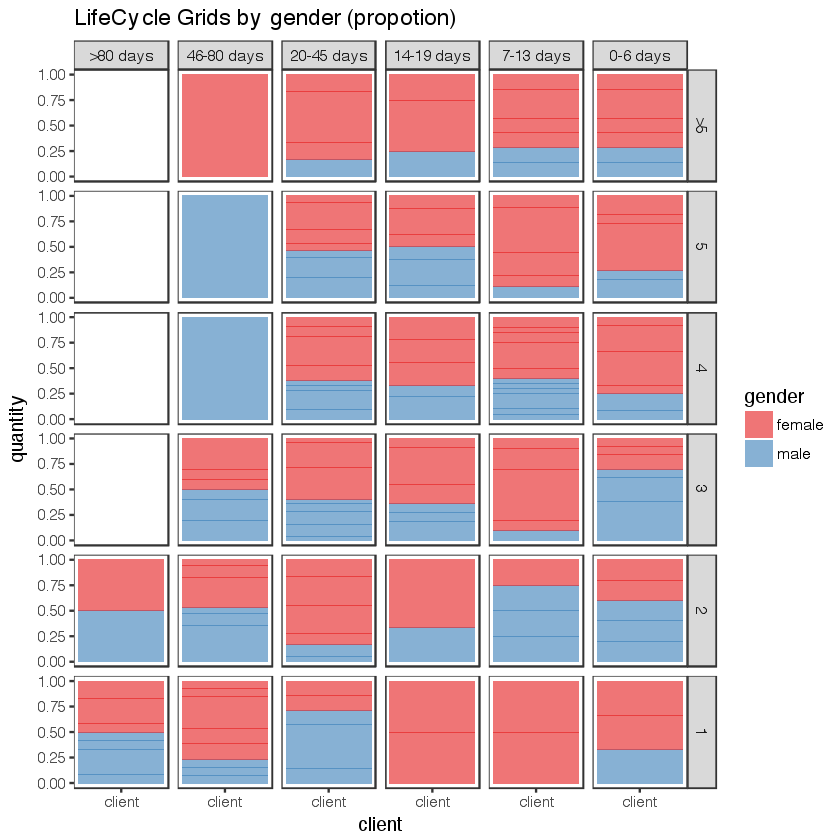

In [30]:
ggplot(lcg.sub, aes(x=client, y=quantity, fill=gender)) +
 theme_bw() +
 scale_fill_brewer(palette='Set1') +
 theme(panel.grid = element_blank())+
 geom_bar(stat='identity', position='fill' , alpha=0.6) +
 facet_grid(segm.freq ~ segm.rec) +
 ggtitle("LifeCycle Grids by gender (propotion)")

or even:

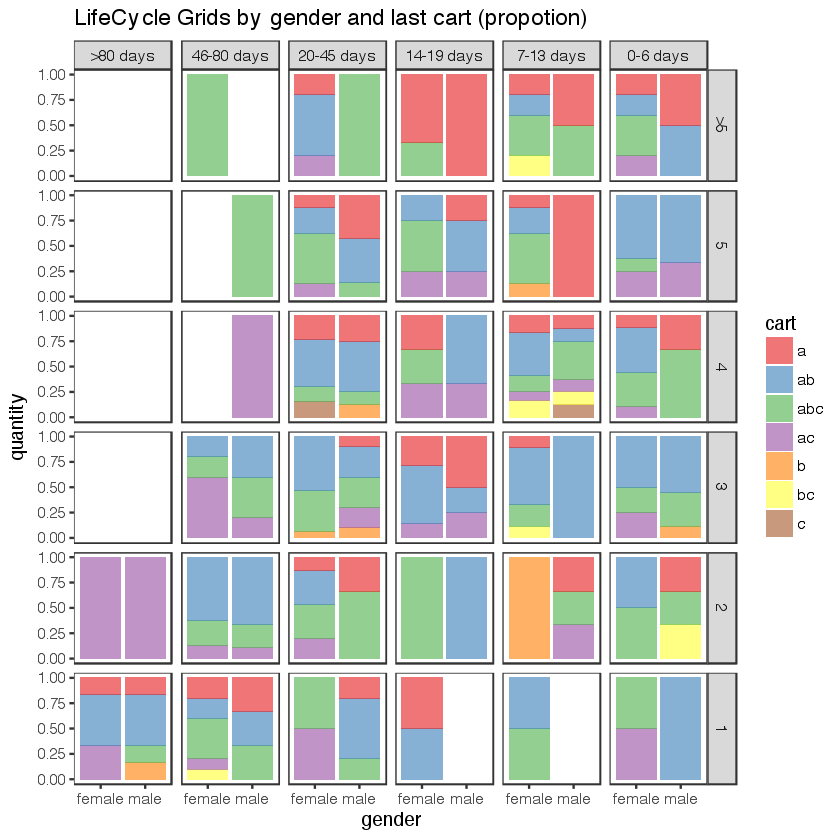

In [31]:
ggplot(lcg.sub, aes(x=gender, y=quantity, fill=cart)) +
 theme_bw() +
 scale_fill_brewer(palette='Set1') +
 theme(panel.grid = element_blank())+
 geom_bar(stat='identity', position='fill' , alpha=0.6) +
 facet_grid(segm.freq ~ segm.rec) +
 ggtitle("LifeCycle Grids by gender and last cart (propotion)")

Therefore, there is a lot of space for creativity. If you want to know much more about LifeCycle Grids and strategies for working with quadrants, I highly recommend that you read Jim Novo’s works, e.g. this blogpost.

Thank you for reading this!